Ramsey Fringes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [111]:
# set initial values
p11, p22, p33 = 0.5, 0.5, 0 #density matrix values
p12, p13, p23 = 0, 0, 0

I1, I2 = 1, 1 #light intensities

# constants (SI units)
e_charge = 1.602e-19
e_mass = 9.109e-31
epsilon_0 = 8.854e-12
hbar = 1.055e-34
bohr_rad = 4 * np.pi * epsilon_0 * hbar**2 / (e_mass * e_charge**2)
c = 2.998e8

# 87Rb constants
g_decay = 36.1  # [MHz] 87Rb D1
g31 = g_decay/2
g32 = g_decay/2
gf = g_decay/2  # decoherence rate between ground and excited states
gs = 0  # decoherence rate between ground states

n = 1  #refractive index
dipole = 2.992 * e_charge * bohr_rad  #transition dipole moment
E1_amplitude = (2 / (n*epsilon_0*c) * I1) ** (1/2)
E2_amplitude = (2 / (n*epsilon_0*c) * I2) ** (1/2)
w1 = dipole / hbar * E1_amplitude * 1e-6  # [MHz] Rabi frequencies
w2 = dipole / hbar * E2_amplitude * 1e-6  # [MHz] assume light polarization parallel to dipole moment



t1 = 10  # [mus]
tfree = 10  # [mus]
tmeasure = 1  # [mus]


# initialize other variables

P0 = np.array([p11, p22, p12, p13, p23], dtype='complex')

on = (w1, w2)
off = (0,0)

t1span = (0, t1)
tfreespan = (0, tfree)

In [16]:
print(gf)
print(w1)
print(w2)

18.05
6.606320532394711
6.606320532394711


In [71]:
# eoms

def dP_dt(t, P, w1, w2, d1, d2):
    p11, p22, p12, p13, p23 = P
    p33 = 1-p11-p22
    p21 = np.conj(p12)
    p31 = np.conj(p13)
    p32 = np.conj(p23)
    
    Pt = np.zeros(5, dtype='complex')
    
    Pt[0] = 1j * w1/2 * (p31 - p13) + g31*(p33) + gs*(p22 - p11)
    Pt[1] = 1j * w2/2 * (p32 - p23) + g32*(p33) - gs*(p22 - p11)
    Pt[2] = 1j * ((d1+d2)*p12 + w1/2*p32 - w2/2*p13) - gs*p12
    Pt[3] = 1j * (d1*p13 + w1/2*(p33-p11) - w2/2*(p12)) - gf*p13
    Pt[4] = 1j * (-1*d2*p23 - w1/2*p21 + w2/2*(p33-p22)) - gf*p23
    return Pt


In [ ]:
'''
def ramsey_old(P, first_step, max_step):
    
    P_measured = np.zeros(5, dtype='complex')
    P_curr = np.zeros(5, dtype='complex')
    for i in range(5):
        P_curr[i] = P[i]
    
    # pulse
    result = solve_ivp(dP_dt, t1span, P_curr, args=on, t_eval=[tmeasure, t1], first_step=first_step, max_step=max_step)
    for j in range(5):
        P_measured[j] = result.y[j, 0]
        P_curr[j] = result.y[j, 1]
    
    # free evolution
    result = solve_ivp(dP_dt, tfreespan, P_curr, args=off, t_eval=[tfree], first_step=first_step, max_step=max_step)
    for j in range(5):
        P_curr[j] = result.y[j, 0]
        
    return P_measured, P_curr
    
'''

Text(0.5, 1.0, 'CPT with CW')

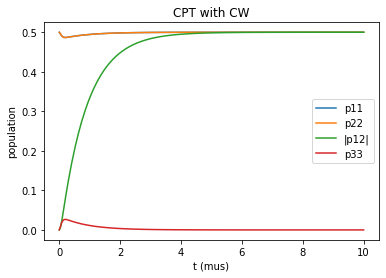

In [112]:
def cw(t, P, d1, d2, first_step, max_step):
    tspan=(0,t)
    detuning=(d1,d2)
    return solve_ivp(dP_dt, tspan, P, args=on+detuning, first_step=first_step, max_step=max_step)


pf = cw(t1, P0, 0, 0, 0.5, 10)
t = pf.t
p11, p22, p12, p13, p23 = pf.y
plt.plot(t, p11.real, label='p11')
plt.plot(t, p22.real, label='p22')
plt.plot(t, abs(p12), label='|p12|')
p33 = np.subtract(np.ones(len(p11)), np.add(p11, p22))
plt.plot(t, p33.real, label='p33')
plt.legend()
plt.xlabel('t (mus)')
plt.ylabel('population')
plt.title('CPT with CW')

Text(0.5, 1.0, 'free evolution')

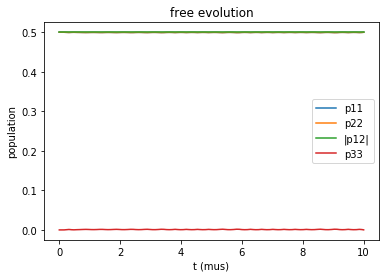

In [114]:
def free(t, P, d1, d2, first_step, max_step):
    tspan=(0,t)
    detuning=(d1,d2)
    return solve_ivp(dP_dt, tspan, P, args=off+detuning, first_step=first_step, max_step=max_step)


p_curr = np.zeros(5, dtype='complex')
for j in range(5):
    p_curr[j] = pf.y[j, -1]
    
pff = free(tfree, p_curr, 0, 0, 0.5, 10)
t = pff.t
p11f, p22f, p12f, p13f, p23f = pff.y
plt.plot(t, p11f.real, label='p11')
plt.plot(t, p22f.real, label='p22')
plt.plot(t, abs(p12f), label='|p12|')
p33f = np.subtract(np.ones(len(p11f)), np.add(p11f, p22f))
plt.plot(t, p33f.real, label='p33')
plt.legend()
plt.xlabel('t (mus)')
plt.ylabel('population')
plt.title('free evolution')

In [90]:
def ramsey(P, d1, d2, first_step, max_step):
    
    # pulse
    result = cw(t1, P, d1, d2, first_step, max_step)

    p_curr = np.zeros(5, dtype='complex')
    for j in range(5):
        p_curr[j] = result.y[j, -1]
    
    # free evolution
    result2 = free(tfree, p_curr, d1, d2, first_step, max_step)
    p_curr2 = np.zeros(5, dtype='complex')
    for j in range(5):
        p_curr2[j] = result2.y[j, -1]
        
    result3 = cw(tmeasure, p_curr2, d1, d2, first_step, max_step)
    # p_final = np.zeros(5, dtype='complex')

    return result3

Text(0.5, 1.0, 'evolution during second pulse')

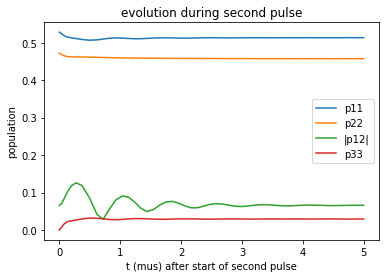

In [115]:
tmeasure=5
final = ramsey(P0, 8, 0, 0.5, 10)
p11, p22, p12, p13, p23 = final.y
t = final.t
p33 = np.subtract(np.ones(len(p11)), np.add(p11, p22))

plt.plot(t, p11.real, label='p11')
plt.plot(t, p22.real, label='p22')
plt.plot(t, abs(p12), label='|p12|')
plt.plot(t, p33.real, label='p33')
plt.legend()
plt.xlabel('t (mus) after start of second pulse')
plt.ylabel('population')
plt.title('evolution during second pulse')

In [ ]:
'''
def repeat_cycle(P_start, n):
    
    P_curr = np.zeros(5, dtype='complex')
    for i in range(5):
        P_curr[i] = P_start[i]
    
    measure11 = np.zeros(n, dtype='complex')
    measure22 = np.zeros(n, dtype='complex')
    
    for i in range(n):
        pops = ramsey(P_curr, 0.25, 10)
        measure11[i] = pops[0][0]
        measure22[i] = pops[0][1]
        P_curr = pops[1]
        
    measure33 = np.subtract(np.ones(n), np.add(measure11, measure22))
    
    return measure33
    
'''

In [ ]:
'''
n_cycles = 2
pop33 = repeat_cycle(P0, n_cycles)

t = np.linspace(0, n_cycles, n_cycles)
plt.xlabel("number of Ramsey cycles")
plt.ylabel("excited state population")
plt.plot(t, pop33.real)


n_cycles = 40
d1, d2 = 4, 0
n = 100
d1_0 = np.linspace(-1*d1, d1, num=n)
pop33_avg = np.zeros(n)
for i in range(n):
    d1 = d1_0[i]
    pop33 = repeat_cycle(P0, n_cycles)
    last = pop33[int(n_cycles*0.6):]
    pop33_avg[i] = sum(last.real)/len(last)

plt.xlabel("detuning")
plt.ylabel("excited state population")
plt.title('Ramsey fringes for 2-pulse sequence')
plt.plot(d1_0, pop33_avg.real)
'''

Text(0.5, 1.0, 'cw resonance')

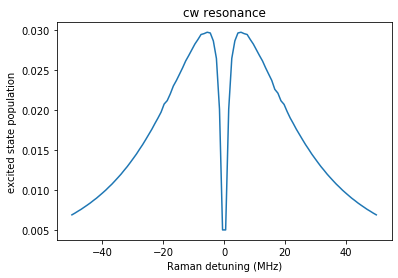

In [117]:
d1_max = 50
d2 = 0
n=100
d1_lin = np.linspace(-1*d1_max, d1_max, num=n)
p33=np.ones(n, dtype='complex')
for i in range(n):
    d1 = d1_lin[i]
    result = cw(t1, P0, d1, d2, 0.5, 10)
    p11f = result.y[0,-1]
    p22f = result.y[1,-1]
    p33f = 1-p11f-p22f
    p33[i] = p33f
    

plt.plot(d1_lin, p33.real)
plt.xlabel('Raman detuning (MHz)')
plt.ylabel('excited state population')
plt.title('cw resonance')

Text(0.5, 1.0, 'Ramsey fringes')

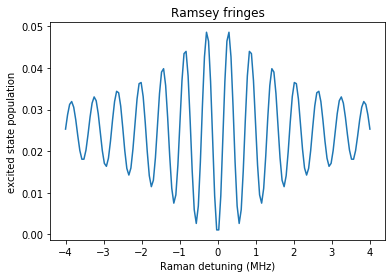

In [119]:
tmeasure=0.3
d1_max = 4
d2 = 0
n=150
d1_lin = np.linspace(-1*d1_max, d1_max, num=n)
p33_ram=np.ones(n, dtype='complex')
for i in range(n):
    d1 = d1_lin[i]
    result = ramsey(P0, d1, d2, 0.1, 10)
    p11f = result.y[0,-1]
    p22f = result.y[1,-1]
    p33f = 1-p11f-p22f
    p33_ram[i] = p33f

plt.plot(d1_lin, p33_ram.real)
plt.xlabel('Raman detuning (MHz)')
plt.ylabel('excited state population')
plt.title('Ramsey fringes')